In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import glob, os, psutil, time

data_path = '../fits/nonlinear_fitzhughnagumo/'
fig_path = '../figs/'

pars=np.load(data_path+'pars.npz')['pars'].tolist()
pars_est_full   = np.load(data_path+'pars_est_full.npz')['pars'].tolist()
pars_est_partial= np.load(data_path+'pars_est_partial.npz')['pars'].tolist()
pars_pca        = np.load(data_path+'pars_pca.npz')['pars'].tolist()
#pars_est_pca= np.load(data_path+'pars_est_pca.npz')['pars'].tolist()

idx_a = pars['idx_a']
idx_b = pars['idx_b']
pa, pb = idx_a.size, idx_b.size
x=np.load(data_path+'x.npz')['x']

p,n = pars['C'].shape
T = x.shape[0]
k,l = pars['k'],pars['l']

mmap, chunksize = True, np.min((T,p))
Qs = []
for m in range(k+l):
        Qs.append(np.memmap(data_path+'Qs_'+str(m), dtype=np.float, 
                      mode='r', shape=(pa,pb)))
        
y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))

/home/mackelab/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


# nonlinear dynamics + linear emissions, latent and observed traces

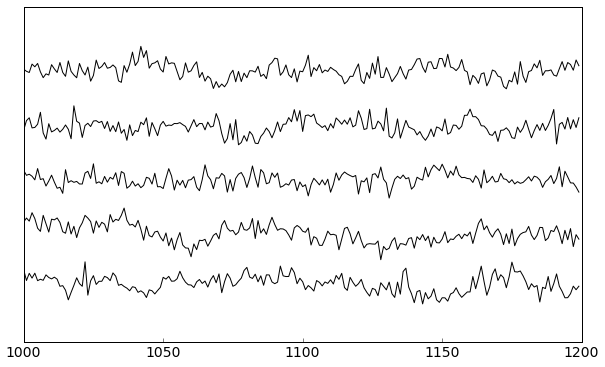

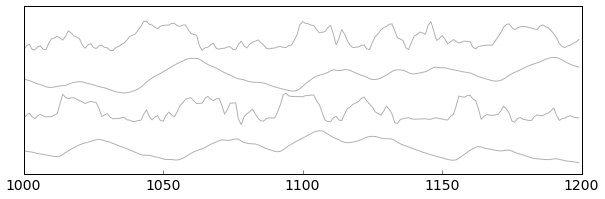

In [2]:
tmin, tmax = 1000, 1200

idx_showy = np.arange(5)
yshow = y[tmin:tmax,idx_showy]
ydiff = yshow.max() - yshow.min()

idx_showx = np.array([0,10,1,11])
xshow = x[tmin:tmax,idx_showx]
xdiff = xshow.max() - xshow.min()

plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i in range(idx_showy.size):
    plt.plot(range(tmin,tmax), i*ydiff + yshow[:,i], 'k')
    plt.hold(True)
    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    
plt.yticks([])    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.xlim(tmin, tmax)    

plt.tick_params(axis="both", which="both", top="off", left='off', right="off", labelleft="on")    

plt.savefig(fig_path + 'figA_y.pdf', bbox_inches="tight"); 
plt.show()


plt.figure(figsize=(10,3))
ax = plt.subplot(111)

for i in range(idx_showx.size):
    plt.plot(range(tmin,tmax), -(xdiff+ydiff)-i*xdiff + xshow[:,i], color=[.7,.7,.7])
    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    
plt.yticks([])    
# Remove the tick marks
plt.tick_params(axis="both", which="both", top="off", left='off', right="off", labelleft="on")    

plt.savefig(fig_path + 'figA_x.pdf', bbox_inches="tight"); 
plt.show()


# quiver plot of nonlinear dynamics

/home/mackelab/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


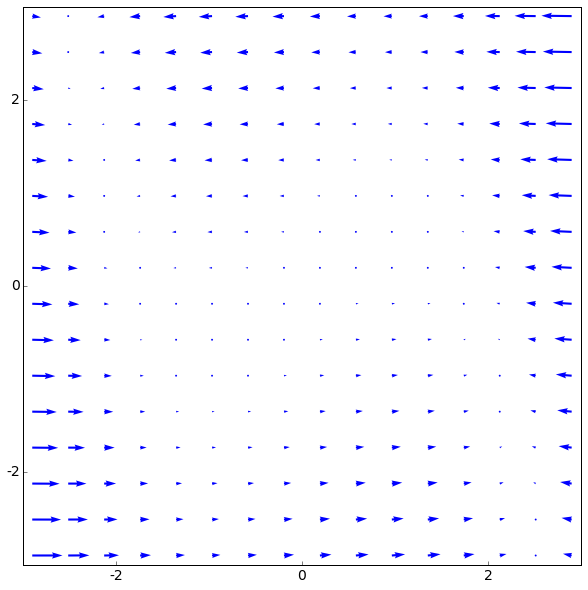

In [3]:
I = 0
def ddt_const(x):
    v,w = x[0],x[1]
    return np.array((v - v**3/3 -w + I, 0.08*(v +0.7-0.8*w)))

# quiver plot

N = 16
V, W = np.meshgrid(np.linspace(-2.9,2.9,N), np.linspace(-2.9,2.9,N))
dV, dW = np.zeros((N,N)), np.zeros((N,N))
for i in range(N):
    for j in range(N):
        tmp = ddt_const(np.array((V[i,j], W[i,j])))
        dV[i,j], dW[i,j] = tmp[0], tmp[1]

        
plt.figure(figsize=(10,10))
plt.quiver(V, W, dV, dW, 
           edgecolor='None', facecolor='b',linewidth=.5, scale=150)

ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

#plt.xlim(tmin, tmax)    
#plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
#plt.xlim(tmin, tmax)    
plt.xticks(range(-2, 3, 2), [str(x) for x in range(-2, 3, 2)], fontsize=14)    
plt.yticks(range(-2, 3, 2), [str(x) for x in range(-2, 3, 2)], fontsize=14)    

plt.savefig(fig_path + 'figA_quiver.pdf', bbox_inches="tight"); 

plt.show()


# goodness of fit for fully observed case (scatter for time-lag m = 0)

computing time-lagged covariance for lag  0


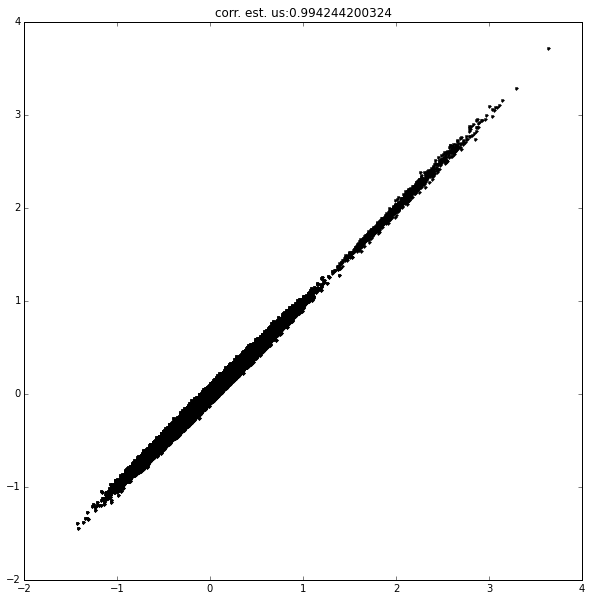

In [4]:
plt.figure(figsize=(10, 10))
for m in range(1):
    print('computing time-lagged covariance for lag ', str(m))
    
    idx_b = idx_a.copy()
    Qf= np.cov(y[m:m-(k+l),idx_a].T, y[:-(k+l),idx_b].T)[:pa,pa:]    
    
    Q = np.empty((pa,pb))
    Q[:] = (pars_est_full['C'][idx_a,:].dot(pars_est_full['X'][:n,:]).dot(pars_est_full['C'][idx_b,:].T)) + np.diag(pars_est_full['R'])[np.ix_(idx_a,idx_b)]
    plt.plot(Qf[:], Q[:], 'k.')
    plt.hold(True)
    plt.title('corr. est. us:' + str(np.corrcoef(Qf.reshape(-1), Q.reshape(-1))[0,1]))
    
    #Q = np.empty((pa,pb))
    #Q[:] = (pars_pca['C'][idx_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idx_b,:].T))
    #plt.plot(Qf[:], Q[:], 'b.')
    
    #plt.xlabel('corr. est. PCA:' + str(np.corrcoef(Qf.reshape(-1), Q.reshape(-1))[0,1]))
    #plt.savefig(fig_path + 'figC_main.pdf', bbox_inches="tight"); 
    plt.show()

# correlations ground-truth-vs.-fit accross time-lags

computing time-lagged covariance for lag  0
computing time-lagged covariance for lag  1
computing time-lagged covariance for lag  2
computing time-lagged covariance for lag  3
computing time-lagged covariance for lag  4
computing time-lagged covariance for lag  5


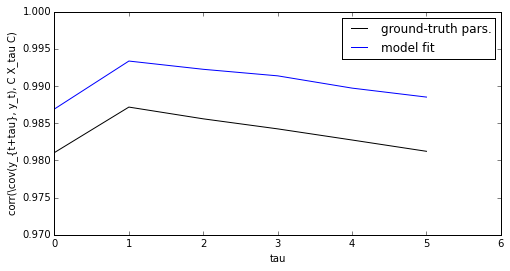

In [18]:
corrs_true, corrs_est = np.zeros(k+l), np.zeros(k+l)
for m in range(k+l):
    print('computing time-lagged covariance for lag ', str(m))
    
    Qf= np.cov(y[m:m-(k+l),idx_a].T, y[:-(k+l),idx_b].T)[:pa,pa:]   

    Qr = pars['C'][idx_a,:].dot(np.cov(x[m:m-(k+l),:].T, x[0:-(k+l),:].T)[:n,n:]).dot(pars['C'][idx_b,:].T)
    Qr = Qr + np.diag(pars['R'])[idx_a,idx_b] if m == 0 else Qr
    
    corrs_true[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]
    
    Qr = pars_est_full['C'][idx_a,:].dot(pars_est_full['X'][m*n:(m+1)*n,:]).dot(pars_est_full['C'][idx_b,:].T)

    corrs_est[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]
    
plt.figure(figsize=(8, 4))
taus = np.arange(0, k+l)
#Qr = pars_pca['C'][idx_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idx_b,:].T)
#plt.plot(0.05, np.corrcoef(Qs[0].reshape(-1), Qr.reshape(-1))[0,1], color='g')
#plt.hold(True)
plt.plot(taus, corrs_true, color='k')
plt.hold(True)
plt.plot(taus, corrs_est, color='b')
plt.axis([0, k+l, 0.97, 1])
plt.legend(('ground-truth pars.', 'model fit'))
plt.xlabel('tau')
plt.ylabel('corr(\cov(y_{t+tau}, y_t), C X_tau C'')')
plt.savefig(fig_path + 'corrs_vs_tau_fully_obs.pdf', bbox_inches="tight"); 
plt.show()
np.savez(fig_path + 'corrs_vs_tau_fully_obs', {'corrs_true' : corrs_true, 'corrs_est' : corrs_est})        

# nonlinear dynamics + linear emissions, partially observed case

# observed traces (latent same as above)

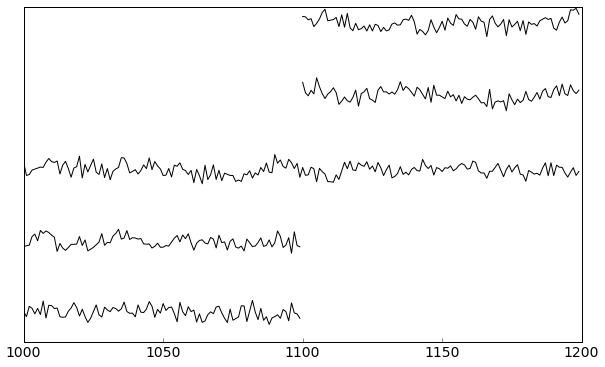

In [9]:
tmin, tmax = 1000, 1200
tmid  = (tmax+tmin) // 2

idx_showy1  = np.arange(5,7)
idx_showy12 = np.array([7])
idx_showy2  = np.arange(8,10)

yshow = y[tmin:tmax,:]
ydiff = yshow.max() - yshow.min()

idx_showx = np.array([0,10])
xshow = x[tmin:tmax,idx_showx]
xdiff = xshow.max() - xshow.min()

plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i in idx_showy1:
    plt.plot(range(tmin,tmid), i*ydiff + yshow[np.arange(0,tmid-tmin),i], 'k')
    plt.hold(True)
for i in idx_showy12:
    plt.plot(range(tmin,tmax), i*ydiff + yshow[np.arange(0,tmax-tmin),i], 'k')
for i in idx_showy2:
    plt.plot(range(tmid,tmax), i*ydiff + yshow[np.arange(tmid-tmin,tmax-tmin),i], 'k')
    
    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    
"""
for i in range(idx_showx.size):
    plt.plot(range(tmin,tmax), -(xdiff+ydiff)-i*xdiff + xshow[:,i], color=[.7,.7,.7])
"""
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    
plt.yticks([])    

# Remove the tick marks
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on")    

plt.savefig('figD_y.pdf', bbox_inches="tight")  
plt.show()


# scatter plots for observed covariances (moving to Matlab for this)

In [ ]:
plt.figure(figsize=(10, 10))
for m in range(1):
    
    idx_sa = np.arange(5500,p) # lower square of not concurrently 
    idx_sb = idx_sa.copy()
    #idx_sb = np.arange(0,4500) # observed covariance
    psa, psb = idx_sa.size, idx_sb.size
    
    print('computing time-lagged covariance for lag ', str(m))
    
    
    Qf = np.cov(y[m:m-(k+l),idx_sa].T, y[:-(k+l),idx_sb].T)[:psa,psb:]    
    
    Q = (pars_est_partial['C'][idx_sa,:].dot(pars_est_partial['X'][:n,:]).dot(pars_est_partial['C'][idx_sb,:].T))
    Q += np.diag(pars_est_partial['R'])[np.ix_(idx_sa,idx_sb)]
    plt.plot(Qf[:], Q[:], 'k.')
    plt.hold(True)
    plt.title('corr. est. us:' + str(np.corrcoef(Qf.reshape(-1), Q.reshape(-1))[0,1]))
    
    #Q = np.empty((pa,pb))
    #Q[:] = (pars_pca['C'][idx_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idx_b,:].T))
    #plt.plot(Qf[:], Q[:], 'b.')    
    #plt.xlabel('corr. est. PCA:' + str(np.corrcoef(Qf.reshape(-1), Q.reshape(-1))[0,1]))
    plt.show()

In [ ]:
#from scipy.io import savemat
#savemat('../fits/partially_obs_covs', {'Q': Q, 'Q_true' : Qf})

# scatter plots for stitched covariances (moving to Matlab for this)

In [ ]:
plt.figure(figsize=(10, 10))
for m in range(1):
    
    idx_sa = np.arange(0,4500) # lower square of not concurrently 
    idx_sb = np.arange(5500,p) # observed covariance
    psa, psb = idx_sa.size, idx_sb.size
    
    print('computing time-lagged covariance for lag ', str(m))
    
    
    Qf = np.cov(y[m:m-(k+l),idx_sa].T, y[:-(k+l),idx_sb].T)[:psa,psb:]    
    
    Q = (pars_est_partial['C'][idx_sa,:].dot(pars_est_partial['X'][:n,:]).dot(pars_est_partial['C'][idx_sb,:].T))
    Q += np.diag(pars_est_partial['R'])[np.ix_(idx_sa,idx_sb)]
    #plt.plot(Qf[:], Q[:], 'k.')
    #plt.hold(True)
    plt.title('corr. est. us:' + str(np.corrcoef(Qf.reshape(-1), Q.reshape(-1))[0,1]))
    
    #Q = np.empty((pa,pb))
    #Q[:] = (pars_pca['C'][idx_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idx_b,:].T))
    #plt.plot(Qf[:], Q[:], 'b.')    
    #plt.xlabel('corr. est. PCA:' + str(np.corrcoef(Qf.reshape(-1), Q.reshape(-1))[0,1]))
    plt.show()

In [ ]:
#from scipy.io import savemat
#savemat('../fits/fully_obs_covs', {'Q': Q, 'Q_true' : Qf})

# correlations ground-truth-vs.-fit accross time-lags

computing time-lagged covariance for lag  0
computing time-lagged covariance for lag  1
computing time-lagged covariance for lag  2
computing time-lagged covariance for lag  3
computing time-lagged covariance for lag  4
computing time-lagged covariance for lag  5


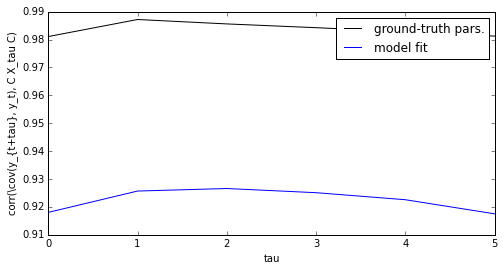

In [17]:
corrs_true, corrs_est = np.zeros(k+l), np.zeros(k+l)
for m in range(k+l):
    print('computing time-lagged covariance for lag ', str(m))
    
    Qf= np.cov(y[m:m-(k+l),idx_a].T, y[:-(k+l),idx_b].T)[:pa,pa:]   

    Qr = pars['C'][idx_a,:].dot(np.cov(x[m:m-(k+l),:].T, x[0:-(k+l),:].T)[:n,n:]).dot(pars['C'][idx_b,:].T)
    Qr = Qr + np.diag(pars['R'])[idx_a,idx_b] if m == 0 else Qr
    
    corrs_true[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]
    
    Qr = pars_est_partial['C'][idx_a,:].dot(pars_est_partial['X'][m*n:(m+1)*n,:]).dot(pars_est_partial['C'][idx_b,:].T)

    corrs_est[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]
    
plt.figure(figsize=(8, 4))
taus = np.arange(0, k+l)
#Qr = pars_pca['C'][idx_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idx_b,:].T)
#plt.plot(0.05, np.corrcoef(Qs[0].reshape(-1), Qr.reshape(-1))[0,1], color='g')
plt.plot(taus, corrs_true, color='k')
plt.hold(True)
plt.plot(taus, corrs_est, color='b')
#plt.axis([0, k+l, 0.97, 0.999])
plt.legend(('ground-truth pars.', 'model fit'))
plt.xlabel('tau')
plt.ylabel('corr(\cov(y_{t+tau}, y_t), C X_tau C'')')
plt.savefig(fig_path + 'corrs_vs_tau_stitched.pdf', bbox_inches="tight"); 
plt.show()
np.savez(fig_path + 'corrs_vs_tau_stitched', {'corrs_true' : corrs_true, 'corrs_est' : corrs_est})    

# large linear system

# latent and observed traces

In [ ]:
tmin, tmax = 1000, 1200

y = np.load('../fits/y_lin_n100.npz')['arr_0'].tolist()['y']     

idx_showy = np.arange(5)
yshow = y[tmin:tmax,idx_showy]
ydiff = yshow.max() - yshow.min()

plt.figure(figsize=(10,6))
ax = plt.subplot(111)
for i in range(idx_showy.size):
    plt.plot(range(tmin,tmax), i*ydiff + yshow[:,i], 'k')
    plt.hold(True)
    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    
plt.yticks([])    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.xlim(tmin, tmax)    

plt.tick_params(axis="both", which="both", top="off", left='off', right="off", labelleft="on")    

plt.savefig(fig_path + 'linear_dynamics_full_activity.pdf', bbox_inches="tight"); 
plt.show()

x = np.load('../fits/x_lin_n100.npz')['arr_0'].tolist()['x']                 # ...

idx_showx = np.array([0,1,2])
xshow = x[tmin:tmax,idx_showx]
xdiff = xshow.max() - xshow.min()

plt.figure(figsize=(10,3))
ax = plt.subplot(111)

for i in range(idx_showx.size):
    plt.plot(range(tmin,tmax), -(xdiff+ydiff)-i*xdiff + xshow[:,i], color=[.7,.7,.7])
    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    
plt.yticks([])    
# Remove the tick marks
plt.tick_params(axis="both", which="both", top="off", left='off', right="off", labelleft="on")    

plt.savefig(fig_path + 'linear_dynamics_latent_traces.pdf', bbox_inches="tight"); 
plt.show()


# (scatter plot for m=0 directly made on the machine where the data lies) 

# (computation of corrs vs. time-lag also done directly there)